In [1]:
import emoji
import nltk
import numpy as np
import os
import pandas as pd
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer as ps
from nltk.tokenize import word_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from stop_words import get_stop_words
from textblob import TextBlob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
%matplotlib inline

denial = ['not', 'cannot', 'doesn',  "wasn't", 'nor', 'couldn', 'weren', 
          "won't", "doesn't", 'needn', "isn't", 'against', "couldn't", 
          'aren', 'isn', 'hadn', 'wouldn', "mightn't", "mustn't", "can't", 
          "wouldn't", 'cant', 'didn', "shouldn't",  "don't", "didn't", 
          "hadn't", "needn't", 'shouldn', 'hasnt', "weren't", 'no', "aren't", 
          "hasn't", "haven't"]
stopwords_english = list(set(get_stop_words("en") + 
                             stopwords.words('english') +
                             list(ENGLISH_STOP_WORDS) +
                             ['user']).difference(denial))

max_words = 2000
max_len = 18
num_classes = 1

morph_analyz = MorphAnalyzer()
nltk.download('punkt')

#Training
epochs = 10
batch_size = 512
print_batch_n = 100

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
len(stopwords_english)

373

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name()

'NVIDIA GeForce MX250'

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
text = 'He is suffering 14 from fever 🤒. 123 Stringg witth lotts of spelingg erors.' \
       '<h1> This is a h1 tag </h1>. FyI I was afk for a while 56. My profile link: https://www.kaggle.com/kasjanov'

#### Data load

In [8]:
DATA_ROOT = 'D:/Data/Study/twitter_sentiment_analysis/'

In [9]:
df_train = pd.read_csv(DATA_ROOT + 'train.csv')
df_test = pd.read_csv(DATA_ROOT + 'test.csv')

In [10]:
df_train.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


array([<AxesSubplot:ylabel='label'>], dtype=object)

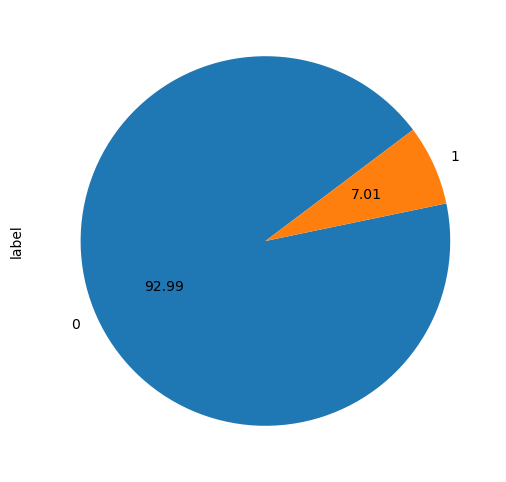

In [11]:
df_train['label'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))

In [12]:
df_test.head(5)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


#### Downsampling

In [13]:
pos_twit = df_train[df_train["label"] == 0]
neg_twit = df_train[df_train["label"] == 1]

In [14]:
pos_twit.shape, neg_twit.shape

((29720, 3), (2242, 3))

In [15]:
downsamp = resample(pos_twit, replace=True, n_samples=int(len(neg_twit) * 1.05), random_state=42)

In [16]:
downsamp['label'].value_counts()

0    2354
Name: label, dtype: int64

In [17]:
df_train_downsamp = pd.concat([downsamp, neg_twit])

In [18]:
df_train_downsamp['label'].value_counts()

0    2354
1    2242
Name: label, dtype: int64

In [19]:
df_train_downsamp.sort_index(inplace=True)

In [20]:
df_train_downsamp

,id,label,tweet
9,10,0,@user @user welcome here ! i'm it's so #gr...
9,10,0,@user @user welcome here ! i'm it's so #gr...
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
...,...,...,...
31947,31948,1,@user @user you don't have the balls to hashta...
31948,31949,1,"makes you ask yourself, who am i? then am i a..."
31952,31953,0,@user you went too far with @user
31956,31957,0,off fishing tomorrow @user carnt wait first ti...


In [21]:
df_train_downsamp.drop_duplicates(inplace=True)

In [22]:
df_train_downsamp

,id,label,tweet
9,10,0,@user @user welcome here ! i'm it's so #gr...
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
...,...,...,...
31947,31948,1,@user @user you don't have the balls to hashta...
31948,31949,1,"makes you ask yourself, who am i? then am i a..."
31952,31953,0,@user you went too far with @user
31956,31957,0,off fishing tomorrow @user carnt wait first ti...


array([<AxesSubplot:ylabel='label'>], dtype=object)

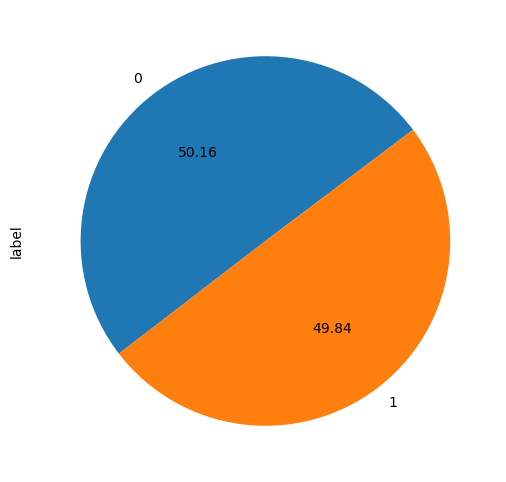

In [23]:
df_train_downsamp['label'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))

In [24]:
df_test_downsamp = resample(df_test, replace=True, n_samples=1050, random_state=42)

In [25]:
df_test_downsamp.drop_duplicates(inplace=True)

In [26]:
df_test_downsamp

,id,tweet
15795,47758,our #bahrain #showroom signboard is almost don...
860,32823,#ripantonyelchin died in a car accident at 27....
5390,37353,i am wholesome. #i_am #positive #affirmation
11964,43927,@user @user represent! @user @user @user in ha...
11284,43247,@user what happened to your receding hairline ...
...,...,...
16774,48737,"@user #saturday people, hopefully you're no..."
12045,44008,see you tomorow!!!
4430,36393,please be good to each other #worldpeace #spir...
8820,40783,"#we #are #so "" "" #to #drink #coffee #togeth..."


#### Text preprocessing

In [27]:
class Text_Preprocessing:
    def __init__(self, text):
        Text_Preprocessing.text = text
        # Some chat words examples
        Text_Preprocessing.chat_words = {
            'FYI' : 'for your information',
            'LOL' : 'laugh out loud',
            'AFK' : 'away from keyboard',
            '4U'  : 'for you',
            'NY'  : 'New York'
        }
    
    # Chat word treatment
    @classmethod
    def chat_words_conv(cls):
        new_text = []
        for word in cls.text.split():
            if word.upper() in cls.chat_words:
                new_text.append(cls.chat_words[word.upper()])
            else:
                new_text.append(word)

        cls.text =  ' '.join(new_text)
        return cls

    # Spelling Correction
    @classmethod
    def spelling_corr(cls):
        cls.text = TextBlob(cls.text).correct().string
        return cls
    
    # Removing URLs
    @classmethod
    def remove_url(cls):
        re_url = re.compile('https?://\S+|www\.\S+')
        cls.text = re_url.sub('', cls.text)
        return cls
    
    # Handling Emojis
    @classmethod
    def demojize_emoji(cls):
        cls.text = emoji.demojize(cls.text)
        return cls
    
    # Lowercasing
    @classmethod
    def convert_lowercase(cls):
        cls.text = cls.text.lower()
        return cls
    
    # Removing HTML Tags
    @classmethod
    def remove_html_tags(cls):
        re_html = re.compile('<.*?>')
        cls.text = re_html.sub(r'', cls.text)
        return cls
    
    # Removing digits
    @classmethod
    def remove_digits(cls):
        cls.text = ''.join(filter(lambda x: not x.isdigit(), cls.text))
        return cls
    
    # Stemming
    @classmethod
    def perform_stemming(cls):
        new_text = [ps().stem(word) for word in cls.text.split()]
        cls.text = ' '.join(new_text)
        return cls
    
    # MorphAnalyzer
    @classmethod
    def morph_analyzer(cls):
        cls.text = ' '.join([morph_analyz.parse(word)[0].normal_form for word in cls.text.split()])
        return cls
    
    # Removing Punctuations
    @classmethod
    def remove_punc(cls):
        cls.text = cls.text.translate(str.maketrans('', '', string.punctuation))
        return cls
    
    # Removing stop words
    @classmethod
    def remove_stopwords(cls):
        new_text = []
        for word in cls.text.split():
            if word in stopwords_english:
                continue
            else:
                new_text.append(word)

        cls.text = ' '.join(new_text)
        return cls


In [28]:
text

'He is suffering 14 from fever 🤒. 123 Stringg witth lotts of spelingg erors.<h1> This is a h1 tag </h1>. FyI I was afk for a while 56. My profile link: https://www.kaggle.com/kasjanov'

In [29]:
Text_Preprocessing(text).remove_digits().remove_html_tags().spelling_corr().text

'He is suffering  from fever 🤒.  String with lots of spelling errors. His is a h tag . by I was ask for a while . By profile link: http://www.angle.com/kasjanov'

In [30]:
def text_preprocess(text):
    return (Text_Preprocessing(text)
            .chat_words_conv()
            .remove_url()
            .demojize_emoji()
            .remove_html_tags()
            .remove_digits()
            .convert_lowercase()
            .spelling_corr()
            .remove_punc()
            .remove_stopwords()
            .perform_stemming()
            .morph_analyzer()).text

In [31]:
df_train_downsamp.head(5)

,id,label,tweet
9,10,0,@user @user welcome here ! i'm it's so #gr...
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.


In [32]:
%%time
tqdm.pandas()
df_train_downsamp['tweet'] = df_train_downsamp['tweet'].progress_apply(text_preprocess)

100%|██████████████████████████████████████████████████████████████████████████████| 4498/4498 [47:33<00:00,  1.58it/s]

Wall time: 47min 33s


In [33]:
df_train_downsamp.head(5)

,id,label,tweet
9,10,0,welcom im gr
13,14,1,call michigan middl school build wall chant trot
14,15,1,no comment australia opkillingbay seashepherd ...
17,18,1,agre
23,24,1,lump say prove lump


In [34]:
df_train_downsamp.to_csv(DATA_ROOT + 'train_preprocess.csv')

In [35]:
%%time
df_test_downsamp['tweet'] = df_test_downsamp['tweet'].progress_apply(text_preprocess)

100%|██████████████████████████████████████████████████████████████████████████████| 1019/1019 [09:36<00:00,  1.77it/s]

Wall time: 9min 36s


In [36]:
df_test_downsamp.to_csv(DATA_ROOT + 'test_preprocess.csv')

#### Tokenization of texts, compilation of a corpus of texts and a word frequency dictionary

In [37]:
train_corpus = ' '.join(df_train_downsamp['tweet'])

In [38]:
train_corpus

'welcom im gr call michigan middl school build wall chant trot no comment australia opkillingbay seashepherd helpcovedolphin thecov helpcovedolphin agre lump say prove lump unbeliev st centuri wed need like neverump xenophobia let fight against love peac christian grimac perform shot christinarip voic christinagrimmi celebr man play fatherli role father day ð\x9f\x98copyrightth white establish cant bulk folk run love promot great hey white peopl peopl white race ident med\x80¦ alright use amp insecur lure men whitesupremaci far away place no famili member im not interest linguist doesnt address race amp racism power raciolinguist brings\x80¦ not mock drama black breast yeah new button mail ð\x9f\x92\x96 pretti jewelrymak button peopl arent protest tramp republican wonthey tramp usher ampâ\x80¦ happi midday chri evans\x9f\x8e\x87ð\x9f\x8e\x89ð\x9f\x8e\x8að\x9f\x8e\x81ð\x9f\x8e\x82ð\x9f\x8e\x86ð\x9f\x8e\x88 great actor human ð\x9f\x98\x81ð\x9f\x98\x8dð\x9f\x98ð\x9f\x98\x98ð\x9f\x98»ð\x9f

In [39]:
tokens = word_tokenize(train_corpus)
tokens[:5]

['welcom', 'im', 'gr', 'call', 'michigan']

In [40]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [41]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)] # -1 for padding
len(tokens_filtered_top)

1999

In [42]:
tokens_filtered_top[:10]

['amp',
 'love',
 'day',
 'not',
 'like',
 'tramp',
 'thank',
 'racism',
 'white',
 'happi']

In [43]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'amp': 1,
 'love': 2,
 'day': 3,
 'not': 4,
 'like': 5,
 'tramp': 6,
 'thank': 7,
 'racism': 8,
 'white': 9,
 'happi': 10,
 'black': 11,
 'librari': 12,
 'peopl': 13,
 'new': 14,
 'no': 15,
 'time': 16,
 'dont': 17,
 'make': 18,
 'say': 19,
 'good': 20,
 'feel': 21,
 'look': 22,
 'polit': 23,
 'u': 24,
 'girl': 25,
 'want': 26,
 'stop': 27,
 'im': 28,
 'liber': 29,
 'right': 30,
 'women': 31,
 'hate': 32,
 'allahsoil': 33,
 'today': 34,
 'life': 35,
 'cant': 36,
 'drama': 37,
 'year': 38,
 'posit': 39,
 'saw': 40,
 'come': 41,
 'work': 42,
 'think': 43,
 'great': 44,
 'live': 45,
 'need': 46,
 'father': 47,
 'listen': 48,
 'got': 49,
 'wait': 50,
 'america': 51,
 'world': 52,
 'midday': 53,
 'way': 54,
 'famili': 55,
 'against': 56,
 'home': 57,
 'go': 58,
 'sex': 59,
 'your': 60,
 'race': 61,
 'thing': 62,
 'video': 63,
 'ignor': 64,
 'comment': 65,
 'man': 66,
 'hope': 67,
 'book': 68,
 'use': 69,
 'fuck': 70,
 'know': 71,
 'follow': 72,
 'let': 73,
 'best': 74,
 'get': 75,
 'week':

#### Translation of texts in the max_len sequence

In [44]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text)
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in  tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen - len(result))
    return result[-maxlen:] + padding

In [45]:
df_train_downsamp, df_val_downsamp = train_test_split(df_train_downsamp, test_size=0.25, random_state=42)

In [46]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train_downsamp['tweet']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val_downsamp['tweet']])

Wall time: 547 ms


In [47]:
df_train_downsamp['tweet'].iloc[0]

'offic woman worn blue tube'

In [48]:
x_train[0]

array([ 257,   81,  130,  879, 1808,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [49]:
temp = 0
for i in range(len(x_train)):
    tmp = np.where(x_train[i] == 0)[0].min()
    if tmp > temp:
        temp = tmp
print(temp)

16


#### Neural network initialization

In [50]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # Batch size, Lenght sequence, Embedding
        #                            Batch size, Embedding, Lenght sequence         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        
        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        
        return output

#### Wrapper over data

In [51]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [52]:
train_dataset = DataWrapper(x_train, df_train_downsamp['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val_downsamp['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [53]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 18])
torch.Size([512])
tensor(1)


#### Training model

In [54]:
model = Net(vocab_size=max_words)
print(model)
print('Parameters:', sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [56]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
train_acc_history =[]
val_loss_history = []
val_acc_history = []

for  epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the gradient
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
        # error counting on training
        loss = loss.item()
        running_items +=len(labels)
        # metric counting on training
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
    
    # output statistics on the learning process
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f} ' \
          f'Acc: {running_right / running_items:.3f} ', end='. ')
    train_acc_history.append(running_right / running_items)
    running_right, running_items = 0.0, 0.0
    train_loss_history.append(loss)
    
    # output statistics on val data
    val_running_loss, val_running_total, val_running_right = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        val_labels = data[1].to(device)
        val_outputs = model(data[0].to(device))
        
        # error counting on the val
        val_loss = criterion(val_outputs, val_labels.float().view(-1, 1))
        # metric counting on the val
        val_running_total += len(data[1])
        pred_val_labels = torch.squeeze((val_outputs > th).int())
        val_running_right += (val_labels == pred_val_labels).sum()
    
    val_loss_history.append(val_loss.item())
    print(f'Val loss: {val_loss:.3f}. Val acc: {val_running_right/val_running_total}')
    val_acc_history.append(val_running_right / val_running_total)
    
    model.train()

print('Training is finished!')

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/10]. Step [7/7]. Loss: 0.657 Acc: 0.555 . Val loss: 0.613. Val acc: 0.5555555820465088
Epoch [2/10]. Step [7/7]. Loss: 0.454 Acc: 0.732 . Val loss: 1.098. Val acc: 0.7644444704055786
Epoch [3/10]. Step [7/7]. Loss: 0.283 Acc: 0.865 . Val loss: 0.189. Val acc: 0.788444459438324
Epoch [4/10]. Step [7/7]. Loss: 0.206 Acc: 0.938 . Val loss: 0.313. Val acc: 0.8053333163261414
Epoch [5/10]. Step [7/7]. Loss: 0.044 Acc: 0.965 . Val loss: 0.509. Val acc: 0.8266666531562805
Epoch [6/10]. Step [7/7]. Loss: 0.036 Acc: 0.984 . Val loss: 21.670. Val acc: 0.8142222166061401
Epoch [7/10]. Step [7/7]. Loss: 0.022 Acc: 0.988 . Val loss: 20.763. Val acc: 0.8159999847412109
Epoch [8/10]. Step [7/7]. Loss: 0.019 Acc: 0.993 . Val loss: 0.051. Val acc: 0.8177778124809265
Epoch [9/10]. Step [7/7]. Loss: 0.017 Acc: 0.992 . Val loss: 0.540. Val acc: 0.8053333163261414
Epoch [10/10]. Step [7/7]. Loss: 0.004 Acc: 0.994 . Val loss: 0.020. Val acc: 0.8204444646835327
Training is finished!


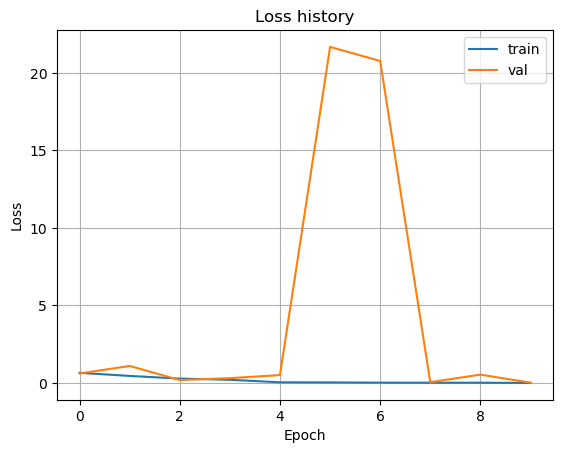

In [57]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend();

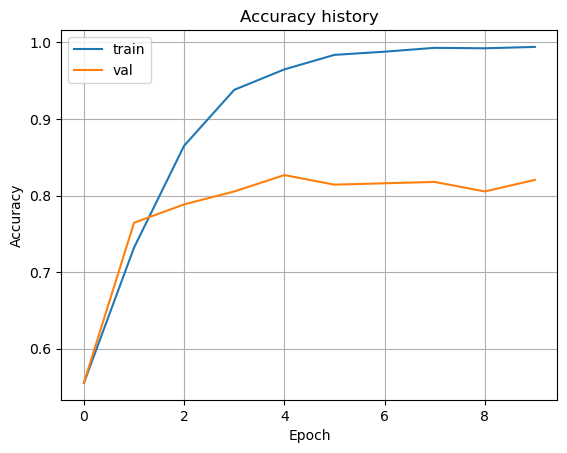

In [58]:
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(torch.stack(train_acc_history).cpu(), label='train')
plt.plot(torch.stack(val_acc_history).cpu(), label='val')
plt.legend();

#### Applying the trained model to test data

In [64]:
torch.save(model, DATA_ROOT + 'model_tweet.pt')

In [65]:
df_test_downsamp['tweet']

15795    brain showroom signboard new look comingsoon k...
860      ripantonyelchin die car accid cant believ like...
5390                                 wholesom posit affirm
11964                        repres hawaii ir symposium ir
11284    happen reced airlin weight bow happi your dead...
                               ...                        
16774    saturday peopl hope your not hunger listen new...
12045                                             tomorrow
4430                                good worldpeac spiritu
8820                   drink coffe june th å´ starbucksâ¦
4232                             fathersday reliabl servic
Name: tweet, Length: 1019, dtype: object

In [66]:
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test_downsamp['tweet']])

In [67]:
df_test_downsamp['tweet'].iloc[0]

'brain showroom signboard new look comingsoon kitchen'

In [68]:
x_test[0]

array([1073,   14,   22,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [77]:
x_test = torch.from_numpy(x_test).to(device)

In [78]:
test_outputs = model(x_test)

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [86]:
pred_test_labels = torch.squeeze((test_outputs > th).int()).detach().cpu().numpy()

In [87]:
pred_test_labels

array([1, 0, 0, ..., 0, 0, 0])

In [88]:
df_test_downsamp['label'] = pred_test_labels

In [89]:
df_test_downsamp

,id,tweet,label
15795,47758,brain showroom signboard new look comingsoon k...,1
860,32823,ripantonyelchin die car accid cant believ like...,0
5390,37353,wholesom posit affirm,0
11964,43927,repres hawaii ir symposium ir,0
11284,43247,happen reced airlin weight bow happi your dead...,0
...,...,...,...
16774,48737,saturday peopl hope your not hunger listen new...,1
12045,44008,tomorrow,0
4430,36393,good worldpeac spiritu,0
8820,40783,drink coffe june th å´ starbucksâ¦,0


array([<AxesSubplot:ylabel='label'>], dtype=object)

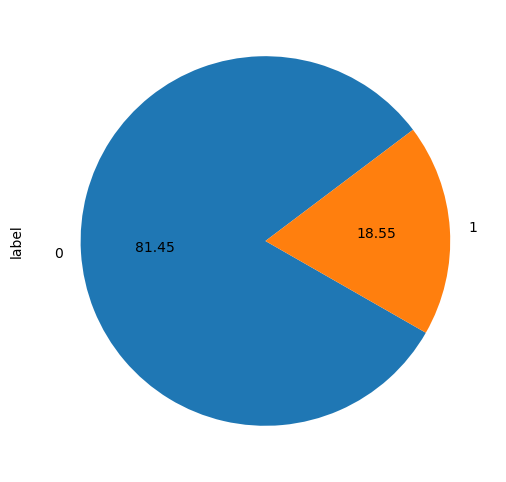

In [91]:
df_test_downsamp['label'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))

In [93]:
df_test_downsamp.to_csv(DATA_ROOT + 'result_tweet.csv')